In [1]:
# Load in the train data

import pandas as pd

df = pd.read_csv('/Users/johnwillis/Desktop/PycharmProjects/data310/m5/final/data/train.csv')
df = df.dropna()
df = df.reset_index()

X = df['title']
y = df.label

In [2]:
# Load in the test data

test_data = pd.read_csv('/Users/johnwillis/Desktop/PycharmProjects/data310/m5/final/data/test.csv')
test_labels = pd.read_csv('/Users/johnwillis/Desktop/PycharmProjects/data310/m5/final/data/submit.csv')
test_data['label'] = test_labels['label'] # Combine the 2 dataframes
test_data = test_data.dropna()
test_data = test_data.reset_index()

X_test = test_data['title']
y_test = test_data.label

In [3]:
# Clean the text

def CleanText(text_bank):
    ''' Clean text prior to tokenization: remove punc/spec char, lowercase,
    split, stem/remove stopwords, rejoin strings and append to corpus.
    The corpus is cleaned text data - useful for WordClouds/graphics.
    '''
    import numpy as np
    from IPython.display import clear_output # for the progress
    from nltk.corpus import stopwords
    import re
    from nltk.stem import PorterStemmer # https://tartarus.org/martin/PorterStemmer/#:~:text=The%20Porter%20Stemming%20Algorithm&text=The%20Porter%20stemming%20algorithm%20(or,setting%20up%20Information%20Retrieval%20systems.
    ps = PorterStemmer()

    corpus = []
    for i in range(len(text_bank)):
        print(np.round((i/len(text_bank)*100),2),'% processed')
        review = (re.sub('[^a-zA-Z]',' ', text_bank[i]))
        review = review.lower().split()
        review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
        
        clear_output(wait=True)
    return corpus

In [4]:
X_corpus = CleanText(X)
X_test_corpus = CleanText(X_test)

99.98 % processed


In [5]:
# View cleaned text

for i in range(2):
    print('Original sentence: ', X[i])
    print('Processed sentence: ', X_corpus[i])

Original sentence:  House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
Processed sentence:  hous dem aid even see comey letter jason chaffetz tweet
Original sentence:  FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart
Processed sentence:  flynn hillari clinton big woman campu breitbart


In [6]:
# Create WordClouds of train and text corpuses

def MakeWordCloud(text, title=None): # FIXXXXXXXX
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    stopwords = set(STOPWORDS)
    
    wordcloud = WordCloud(width=800, height=800,
                          background_color='black',
                          stopwords=stopwords,
                          min_font_size=10).generate(' '.join(X_corpus))
    
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.title('Train WordCloud')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

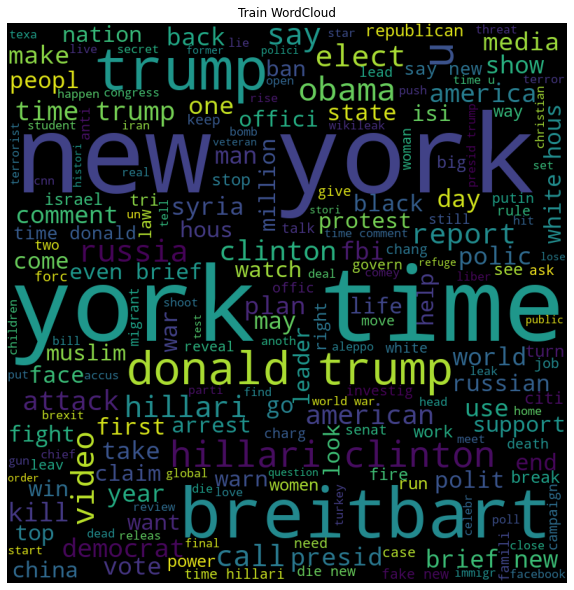

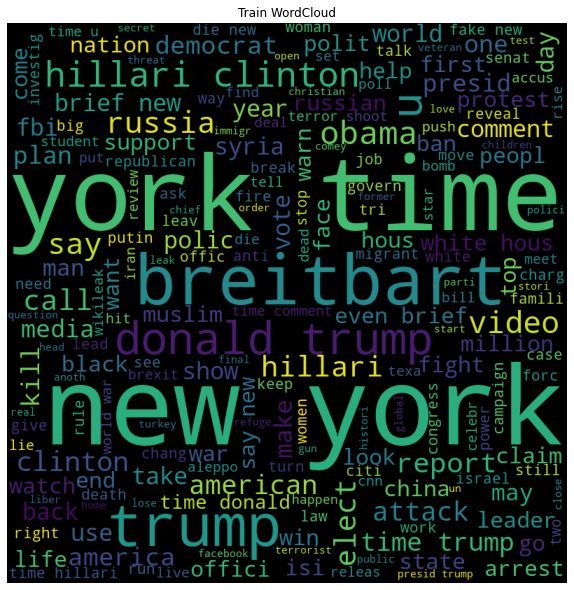

In [7]:
MakeWordCloud(X_corpus, 'Train WordCloud')
MakeWordCloud(X_test_corpus, 'Test WordCloud')

In [8]:
# Encode text into a one-hot tensor

from tensorflow.keras.preprocessing.text import one_hot
VOCAB_SIZE = 5000
onehot_representation=[one_hot(words, VOCAB_SIZE) for words in X_corpus]
onehot_representation_test=[one_hot(words, VOCAB_SIZE) for words in X_test_corpus]

In [9]:
# Pad sequences so they are the same length

from tensorflow.keras.preprocessing.sequence import pad_sequences
PADDING_LENGTH=25
padded_title=pad_sequences(onehot_representation, padding='pre' , maxlen=PADDING_LENGTH)
padded_title_test=pad_sequences(onehot_representation_test, padding='pre' , maxlen=PADDING_LENGTH)

In [10]:
# Split data for training:

import numpy as np

X_train = np.array(padded_title)
y_train = np.array(y)

from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=.2)

In [11]:
# Create the model

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, BatchNormalization

EMBEDDING_OUTPUT_DIM = 40
model = tf.keras.Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_OUTPUT_DIM, input_length=PADDING_LENGTH),
    Dropout(0.4),
    LSTM(100),
    Dropout(0.4),
    Dense(32,activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                3232      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [12]:
# Train the model

history = model.fit(X_train, y_train,
                    validation_data=(X_val,y_val),
                    epochs=4, # 3 epochs to save time
                    batch_size=128)

Epoch 1/4
115/115 [==============================] - 5s 30ms/step - loss: 0.3900 - accuracy: 0.8181 - val_loss: 0.2168 - val_accuracy: 0.9054
Epoch 2/4
115/115 [==============================] - 3s 28ms/step - loss: 0.1693 - accuracy: 0.9369 - val_loss: 0.2067 - val_accuracy: 0.9106
Epoch 3/4
115/115 [==============================] - 3s 28ms/step - loss: 0.1237 - accuracy: 0.9556 - val_loss: 0.2156 - val_accuracy: 0.9111
Epoch 4/4
115/115 [==============================] - 3s 28ms/step - loss: 0.0978 - accuracy: 0.9648 - val_loss: 0.2386 - val_accuracy: 0.9152


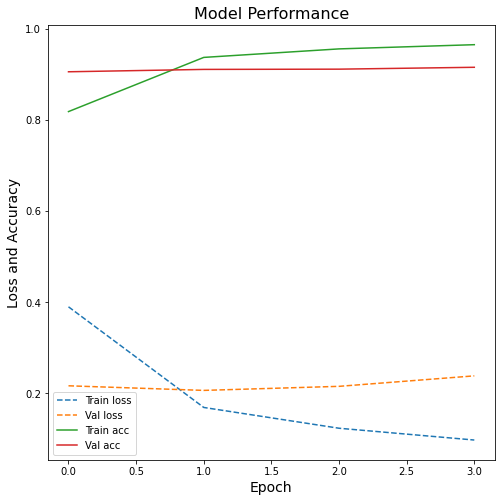

In [13]:
# Plot training results

from matplotlib import pyplot as plt
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'],'--')
plt.plot(history.history['val_loss'],'--')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Performance', fontsize=16)
plt.ylabel('Loss and Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train loss', 'Val loss', 'Train acc', 'Val acc'], loc='best')
plt.show()

In [14]:
# Evaluate the model with test data

X_test = np.array(padded_title_test)
y_test = np.array(y_test)
loss, acc = model.evaluate(X_test, y_test)
print('The model correctly labeled',np.round(acc*100, 2),'% of the testing data')

143/143 [==============================] - 0s 3ms/step - loss: 2.1633 - accuracy: 0.6417
The model correctly labeled 64.17 % of the testing data


/Users/johnwillis/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


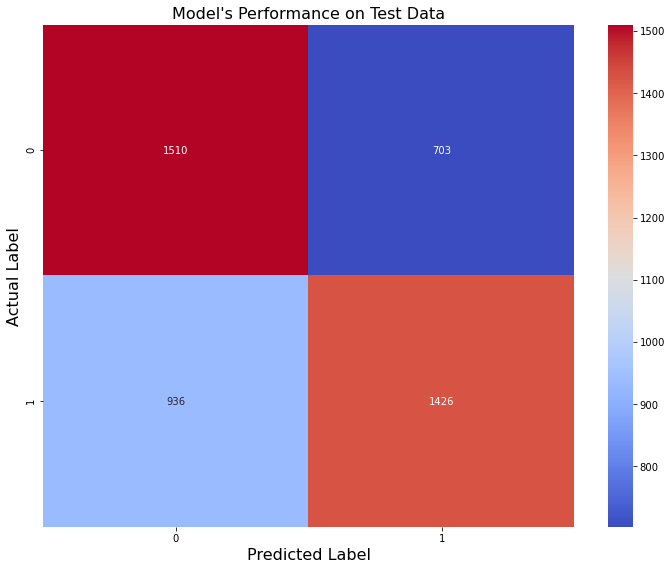

In [15]:
# Plot confusion matrix

from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
cm = confusion_matrix(y_test, y_pred)

import seaborn as sns
plt.figure(figsize = (10,8), facecolor=None)
sns.heatmap(cm, annot=True, cmap=plt.cm.coolwarm, linewidths=0, fmt="d")
plt.title(label=("Model's Performance on Test Data"), fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('Actual Label', fontsize=16)
plt.tight_layout(pad=1)
plt.show()

In [16]:
# See what the model is getting right/wrong

idxRight = [i for i in range(len(y_pred)) if y_pred[i] == y_test[i]]
idxWrong = [i for i in range(len(y_pred)) if y_pred[i] != y_test[i]]

In [17]:
# Print some headlines that were incorrectly classified

for i in range(5):
    if y_pred[idxWrong[i]] == 1:
        print('Incorrectly Labeled Unreliable')
    else:
        print('Incorrectly Labeled Reliable')
    print(X_test_corpus[idxWrong[i]])

Incorrectly Labeled Reliable
tim tebow attempt anoth comeback time basebal new york time
Incorrectly Labeled Reliable
pelosi call fbi investig find russian donald trump breitbart
Incorrectly Labeled Unreliable
u gener admir endors trump command chief
Incorrectly Labeled Unreliable
rise mandatori vaccin mean end medic freedom
Incorrectly Labeled Reliable
colleg republican yaf sue berkeley ann coulter event breitbart


In [ ]:
# Analyzing word groupings

In [18]:
# Create separate indexes of fake/real training and testing headlines

test_idxFake = [i for i in range(len(test_data['label'])) if (test_data['label'][i]) == 1] # idx of fake training headlines
test_idxReal = [i for i in range(len(test_data['label'])) if (test_data['label'][i]) == 0]

train_idxFake = [i for i in range(len(df['label'])) if (df['label'][i]) == 1]  # idx of fake training headlines
train_idxReal = [i for i in range(len(df['label'])) if (df['label'][i]) == 0]  # idx of fake training headlines

In [19]:
# Print out some FAKE headlines (original form, not cleaned)

for i in range(5): 
    print('Fake Train Headline ',i,":",df['title'][train_idxFake[i]])
    print('Fake Test Headline ',i,":",test_data['title'][test_idxFake[i]])

Fake Train Headline  0 : House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It
Fake Test Headline  0 : Tim Tebow Will Attempt Another Comeback, This Time in Baseball - The New York Times
Fake Train Headline  1 : Why the Truth Might Get You Fired
Fake Test Headline  1 : Keiser Report: Meme Wars (E995)
Fake Train Headline  2 : 15 Civilians Killed In Single US Airstrike Have Been Identified
Fake Test Headline  2 : Pelosi Calls for FBI Investigation to Find Out ’What the Russians Have on Donald Trump’ - Breitbart
Fake Train Headline  3 : Iranian woman jailed for fictional unpublished story about woman stoned to death for adultery
Fake Test Headline  3 : Weekly Featured Profile – Randy Shannon
Fake Train Headline  4 : Russian Researchers Discover Secret Nazi Military Base ‘Treasure Hunter’ in the Arctic [Photos]
Fake Test Headline  4 : “Working Class Hero” by John Brennon


In [20]:
# Print out some REAL headlines (original form, not cleaned)

for i in range(5): 
    print('Real Train Headline ', i, ":", df['title'][train_idxReal[i]])
    print('Real Test Headline ', i, ":", test_data['title'][test_idxReal[i]])

Real Train Headline  0 : FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart
Real Test Headline  0 : Specter of Trump Loosens Tongues, if Not Purse Strings, in Silicon Valley - The New York Times
Real Train Headline  1 : Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart
Real Test Headline  1 : #NoDAPL: Native American Leaders Vow to Stay All Winter, File Lawsuit Against Police
Real Train Headline  2 : Benoît Hamon Wins French Socialist Party’s Presidential Nomination - The New York Times
Real Test Headline  2 : 184 U.S. generals and admirals endorse Trump for Commander-In-Chief
Real Train Headline  3 : A Back-Channel Plan for Ukraine and Russia, Courtesy of Trump Associates - The New York Times
Real Test Headline  3 : The Rise of Mandatory Vaccinations Means the End of Medical Freedom
Real Train Headline  4 : Obama’s Organizing for Action Partners with Soros-Linked ‘Indivisible’ to Disrupt Trump’s Agenda
Rea

In [21]:
# Separate corpora by label

train_corpusFake = [X_corpus[i] for i in train_idxFake]
train_corpusReal = [X_corpus[i] for i in train_idxReal]

test_corpusFake = [X_corpus[i] for i in test_idxFake]
test_corpusReal = [X_corpus[i] for i in test_idxReal]

In [22]:
# Create bigrams

from nltk.util import ngrams

train_FakeBigrams = ngrams((' '.join(train_corpusFake).split(' ')), 2)
train_RealBigrams = ngrams((' '.join(train_corpusReal).split(' ')), 2)

test_FakeBigrams = ngrams((' '.join(test_corpusFake).split(' ')), 2)
test_RealBigrams = ngrams((' '.join(test_corpusReal).split(' ')), 2)

In [23]:
# Find top train bigrams

import collections

train_FakeBigrams_count = collections.Counter(train_FakeBigrams)
tfb_top = train_FakeBigrams_count.most_common(10)

train_RealBigrams_count = collections.Counter(train_RealBigrams)
trb_top = train_RealBigrams_count.most_common(10)

In [24]:
# must be in DF to plot

trb_top_df = pd.DataFrame(trb_top, columns=('bigram', 'count')) 
tfb_top_df = pd.DataFrame(tfb_top, columns=('bigram', 'count')) 
tfb_top_df

,bigram,count
0,"(hillari, clinton)",295
1,"(donald, trump)",200
2,"(world, war)",90
3,"(stand, rock)",66
4,"(clinton, campaign)",64
5,"(trump, support)",56
6,"(trump, win)",55
7,"(clinton, email)",49
8,"(clinton, foundat)",49
9,"(bill, clinton)",42


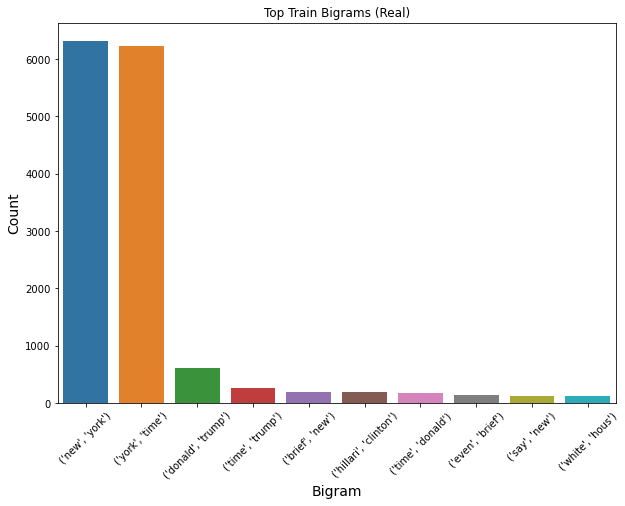

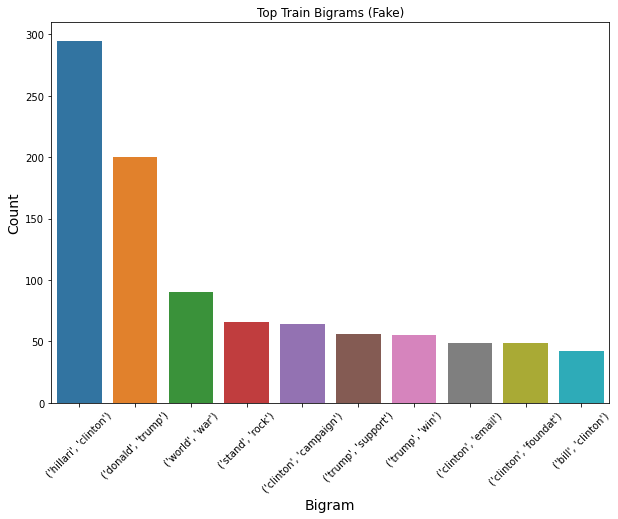

In [25]:
# Plot top train real bigrams

plt.figure(figsize=(10,7))
sns.barplot(x=trb_top_df['bigram'], y=trb_top_df['count'])
plt.title('Top Train Bigrams (Real)')
plt.xlabel('Bigram', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation = 45)
plt.show()

# Plot top fake real bigrams

plt.figure(figsize=(10,7))
sns.barplot(x=tfb_top_df['bigram'], y=tfb_top_df['count'])
plt.title('Top Train Bigrams (Fake)')
plt.xlabel('Bigram', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation = 45)
plt.show()